# Advanced Technologies For Machine Learning
## Final Project - Uber Ride High Fare Predictions
#### Almog Amiga & Omri Kireev


## Getting data from kaggle

In [3]:
#Run this once
!kaggle competitions download -f afeka_train.csv afeka-big-data-ml-competition
!unzip afeka_train.csv.zip
!kaggle competitions download -f afeka_test.csv afeka-big-data-ml-competition
!unzip afeka_test.csv.zip

 99%|████████████████████████████████████████▍| 455M/461M [00:04<00:00, 135MB/s]
100%|█████████████████████████████████████████| 461M/461M [00:04<00:00, 107MB/s]
Archive:  afeka_train.csv.zip
  inflating: afeka_train.csv         
  0%|                                                | 0.00/722k [00:00<?, ?B/s]
100%|█████████████████████████████████████████| 722k/722k [00:00<00:00, 140MB/s]
unzip:  cannot find or open afeka_test.csv.zip, afeka_test.csv.zip.zip or afeka_test.csv.zip.ZIP.


# Notebook run of 1 Worker

In [2]:
%%time
import os
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/usr/bin/python3'
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType, FloatType, ByteType, DateType, TimestampType
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkConf, SparkContext


conf = SparkConf()
conf.set("spark.executor.memory", "16g")
conf.set("spark.driver.memory", "16g")
spark_context = SparkContext.getOrCreate(conf)
spark = SparkSession(spark_context)


spark.conf.set('spark.sql.session.timeZone', 'UTC')

schema = StructType([
    StructField("key", IntegerType()),
    StructField("fare_amount", FloatType()),
    StructField("pickup_datetime", TimestampType()), # Will later extract date and time
    StructField("pickup_longitude", FloatType()),
    StructField("pickup_latitude", FloatType()),
    StructField("dropoff_longitude", FloatType()),
    StructField("dropoff_latitude", FloatType()),
    StructField("passenger_count", ByteType())
])

fileToRead = 'afeka_train.csv'
#fileToRead = '100k_afeka_train.csv'

data = spark.read.format("csv").option("header", "true").schema(schema).option("TimeStampFormat", "yyyy-mm-dd hh:mm:ss").load(fileToRead)

CPU times: user 79.9 ms, sys: 7.3 ms, total: 87.2 ms
Wall time: 4.96 s


## Filter out the unneeded columns, keeping only the ones we want to use

In [2]:
%%time
data.describe().show()

+-------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|              key|       fare_amount|  pickup_longitude|   pickup_latitude| dropoff_longitude| dropoff_latitude|   passenger_count|
+-------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|  count|         19990000|          19990000|          19990000|          19990000|          19989863|         19989863|          19989982|
|   mean|        9995000.5| 11.34479973617804|-72.51207731363243|39.921070113225795|-72.51080146093182| 39.9203144125956|1.6856535438601195|
| stddev|5770616.084887875|16.915900798984428|12.916451525408974| 9.690173781854165|12.773569816080057|9.683144138271158|1.3093239837992636|
|    min|                1|            -300.0|        -3414.1328|        -3478.2412|        -3442.0247|       -3547.8867|                 0|
|    max|    

### Function to calculate distance between two coordinates

In [3]:
from math import cos, asin, sqrt, pi, sin, atan2, radians

def haversine_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0
    
    # Getting latitude and longtitude of both points
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c # Distance in KM
    return distance

def getEuclidean_distance(pickup_long, pickup_lat, dropoff_long, dropoff_lat):
    return sqrt(((pickup_long-dropoff_long)**2) + ((pickup_lat-dropoff_lat)**2))

def get_manhattan_dist(pickup_long, pickup_lat, dropoff_long, dropoff_lat):
    return (abs(dropoff_long - pickup_long) + abs(dropoff_lat - pickup_lat))

def select_within_boundingbox(df):
    BB = (-74.5, -72.8, 40.5, 41.8)
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

### Dropping Key Column

In [4]:
%%time
data = data.drop(data.key)
data.show()

+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|        8.5|2010-03-30 19:27:00|       -73.96539|      40.768574|       -73.998184|       40.761074|              1|
|      35.47|2010-08-10 20:02:03|      -73.967354|      40.769295|       -73.967285|       40.802975|              1|
|        6.1|2011-03-13 13:24:00|       -73.96884|      40.758278|       -73.961395|       40.768566|              1|
|        9.7|2011-06-11 19:45:14|       -73.98218|      40.774796|        -73.95431|        40.78315|              1|
|        7.7|2011-12-03 13:16:02|        -73.9778|       40.74228|       -73.998634|       40.734917|              1|
|      57.33|2013-03-29 14:35:36|       -74.00303|      

### Clearing any missing data

In [5]:
%%time
before = data.count()
print("Before ", before)
data = data.dropna()
after = data.count()
print("After ", after)
print(before - after)

Before  19990000
After  19989845
155
CPU times: user 21.2 ms, sys: 0 ns, total: 21.2 ms
Wall time: 1min 33s


### Adding columns -- will be used as future features

In [6]:
%%time

# Calculating the distance between the pickup and dropoff
from pyspark.sql.functions import udf
import pyspark.sql.functions as F


def add_cols(data, high_fare=True):
    udf_func = udf(getEuclidean_distance,FloatType()) # Creating a 'User Defined Function' to calculate distance between two points.
    data = data.withColumn("distance", udf_func(data.pickup_latitude, data.pickup_longitude, \
                                         data.dropoff_latitude, data.dropoff_longitude))

    #Converting the dates to week days
    from pyspark.sql.functions import dayofweek
    data = data.withColumn("day_of_week", dayofweek(data.pickup_datetime))

    #Converting hour timestap to seconds
    from pyspark.sql.functions import col, second, minute, hour
    data = data.withColumn("numerical_time", (hour(col('pickup_datetime'))*3600 + minute(col('pickup_datetime'))*60 + second(col('pickup_datetime'))))

    #Adding the high fare column
    if high_fare is True:
        data = data.withColumn("high_fare", F.when(F.col('fare_amount') >= 10, 1).otherwise(0))

    # Add year column
    from pyspark.sql.functions import year
    data = data.withColumn("year", year(data.pickup_datetime))

    # Add month column
    from pyspark.sql.functions import month
    data = data.withColumn("month", month(data.pickup_datetime))

    # Add month completion progress value (float 0-1)
    from pyspark.sql.functions import dayofmonth, last_day
    data = data.withColumn("month_completion", dayofmonth(data.pickup_datetime) / dayofmonth(last_day(data.pickup_datetime)))
    
    data = data.withColumn("isInBox", F.when(select_within_boundingbox(data), 1).otherwise(0))
    return data

data = add_cols(data) # Adding all cols for features
data.show()

+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+------------+-----------+--------------+---------+----+-----+-------------------+-------+
|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|    distance|day_of_week|numerical_time|high_fare|year|month|   month_completion|isInBox|
+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+------------+-----------+--------------+---------+----+-----+-------------------+-------+
|        8.5|2010-03-30 19:27:00|       -73.96539|      40.768574|       -73.998184|       40.761074|              1| 0.033637837|          3|         70020|        0|2010|    3|  0.967741935483871|      1|
|      35.47|2010-08-10 20:02:03|      -73.967354|      40.769295|       -73.967285|       40.802975|              1| 0.033680033|          3|         72123|        1|2010|

### Imputing the train data. negative and out_of_bounds

In [7]:
%%time
from pyspark.sql.functions import udf
import pyspark.sql.functions as F

data = data.withColumn("distance", F.when(data["distance"] > 5, 0).otherwise(data["distance"])) # Make all outlier distance zero so we can later impute them

data = data.withColumn("passenger_count", F.when((data["passenger_count"] <= 0) | (data["passenger_count"] > 30) , \
                                                 0).otherwise(data["passenger_count"])) 
data = data.withColumn("fare_amount", F.when((data["fare_amount"] <= 0) | (data["fare_amount"] > 500) , \
                                                 0).otherwise(data["fare_amount"])) 

data = data.withColumn("pickup_longitude", F.when(data["isInBox"] == 1, data['pickup_longitude']).otherwise(0))

data = data.withColumn("dropoff_longitude", F.when(data["isInBox"] == 1, data['dropoff_longitude']).otherwise(0))

data = data.withColumn("pickup_latitude", F.when(data["isInBox"] == 1, data['pickup_latitude']).otherwise(0))

data = data.withColumn("dropoff_latitude", F.when(data["isInBox"] == 1, data['dropoff_latitude']).otherwise(0))

imputeList = ['distance','fare_amount','pickup_longitude','dropoff_longitude','pickup_latitude','dropoff_latitude']
data = data.drop(data.isInBox)

from pyspark.ml.feature import Imputer
imputer = Imputer(strategy='mean', missingValue=0, inputCols=imputeList, outputCols=imputeList) # Imputer for the distance
imputer_model = imputer.fit(data)
data = imputer_model.transform(data)

data = data.withColumn("passenger_count", data["passenger_count"].cast(FloatType()))
imputer = Imputer(strategy='median', missingValue=0, inputCols=['passenger_count'], outputCols=['passenger_count']) # Imputer for passenger_count
imputer_model = imputer.fit(data)
data = imputer_model.transform(data)
data = data.withColumn("passenger_count", data["passenger_count"].cast(ByteType()))


CPU times: user 83.6 ms, sys: 15.9 ms, total: 99.6 ms
Wall time: 3min 35s


## Plotting The Data

### Preparations Before Plotting The Data

In [6]:
%%time
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf


sample_data = data.limit(10_000) # ----- Important Note: limit() isn't guaranteed to always give the same 10,000 rows from the dataframe  -------
sample_data.count()

#Adding hour column
from pyspark.sql.functions import col, second, minute, hour
sample_data = sample_data.withColumn("hours_for_plotly", hour(col('pickup_datetime')))
udf_func = udf(haversine_distance, FloatType()) # Creating a 'User Defined Function' to calculate distance between two points.
sample_data = sample_data.withColumn("haversine_distance", udf_func(sample_data.pickup_latitude, sample_data.pickup_longitude, \
                                         sample_data.dropoff_latitude, sample_data.dropoff_longitude))
pdf = sample_data.toPandas()
pdf.head()

Wall time: 10 s


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,day_of_week,numerical_time,high_fare,year,month,month_completion,hours_for_plotly,haversine_distance
0,8.500000,2010-03-30 19:27:00,-73.965393,40.768574,-73.998184,40.761074,1,0.033638,3,70020,0,2010,3,0.967742,19,2.885694
1,35.470001,2010-08-10 20:02:03,-73.967354,40.769295,-73.967285,40.802975,1,0.033680,3,72123,1,2010,8,0.322581,20,3.746221
2,6.100000,2011-03-13 13:24:00,-73.968842,40.758278,-73.961395,40.768566,1,0.012700,1,48240,0,2011,3,0.419355,13,1.305027
3,9.700000,2011-06-11 19:45:14,-73.982178,40.774796,-73.954308,40.783150,1,0.029095,7,71114,0,2011,6,0.366667,19,2.524654
4,7.700000,2011-12-03 13:16:02,-73.977798,40.742279,-73.998634,40.734917,1,0.022098,7,47762,0,2011,12,0.096774,13,1.937575


### Distribution of ride fairs

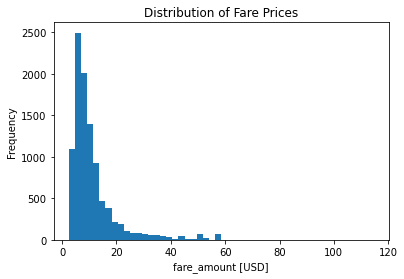

Wall time: 297 ms


In [7]:
%%time
plt.hist(pdf['fare_amount'], bins=50)
plt.xlabel('fare_amount [USD]')
plt.ylabel('Frequency')
plt.title('Distribution of Fare Prices')
plt.show()

# Disribution seems to be normal-ish

### Ride fare vs. Ride length

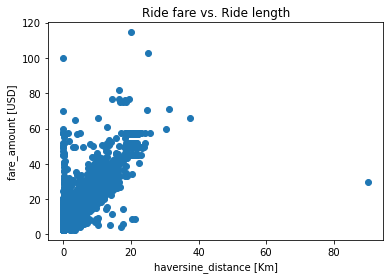

Wall time: 238 ms


In [8]:
%%time
plt.scatter(pdf['haversine_distance'], pdf['fare_amount'])
plt.xlabel('haversine_distance [Km]')
plt.ylabel('fare_amount [USD]')
plt.title('Ride fare vs. Ride length')
plt.show()

### Average ride length per pick up time hour of the day

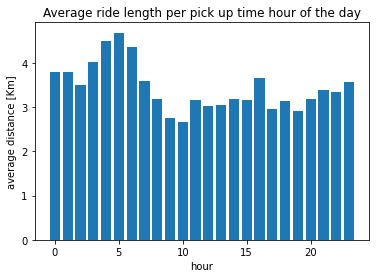

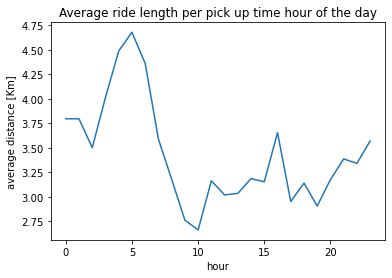

Wall time: 6.15 s


In [9]:
%%time
from pyspark.sql import functions as F
temp = pdf
pdf = sample_data.groupBy('hours_for_plotly').agg(F.mean('haversine_distance').alias('avg_distance')).toPandas()

plt.bar(pdf['hours_for_plotly'], pdf['avg_distance'])
plt.ylabel('average distance [Km]')
plt.xlabel('hour')
plt.title('Average ride length per pick up time hour of the day')
plt.show()
pdf = temp

pdf.groupby('hours_for_plotly')['haversine_distance'].mean().plot()
plt.ylabel('average distance [Km]')
plt.xlabel('hour')
plt.title('Average ride length per pick up time hour of the day')
plt.show()

# Creating the ML model

## Create the Features Vector
### Spark ML expects data to be represented in two columns: a features vector and a label column (in this case high_fare)

In [8]:
%%time
from pyspark.ml.feature import VectorAssembler
newListOfFeatures = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count', 'distance', 'day_of_week', 'numerical_time', 'month_completion', 'month', 'year']
assembler = VectorAssembler(inputCols=newListOfFeatures, outputCol='features')
model_data = assembler.transform(data).select(['features', 'high_fare'])

CPU times: user 1.74 ms, sys: 3.69 ms, total: 5.42 ms
Wall time: 189 ms


In [9]:
%%time
model_data.show(10)

+--------------------+---------+
|            features|high_fare|
+--------------------+---------+
|[-73.965393066406...|        0|
|[-73.967353820800...|        1|
|[-73.968841552734...|        0|
|[-73.982177734375...|        0|
|[-73.977798461914...|        0|
|[-74.003028869628...|        1|
|[-73.964645385742...|        0|
|[-73.969833374023...|        0|
|[-73.990974426269...|        0|
|[-74.002265930175...|        0|
+--------------------+---------+
only showing top 10 rows

CPU times: user 1.44 ms, sys: 280 µs, total: 1.72 ms
Wall time: 382 ms


## Split the data into training and test sets (20% held out for testing)
### Train in the traing set, and evaluate on both the training and test sets

In [10]:
%%time
(trainingData, testData) = model_data.randomSplit([0.8, 0.2])

CPU times: user 2.06 ms, sys: 38 µs, total: 2.1 ms
Wall time: 13.3 ms


## Normalizing the Data

In [11]:
%%time
from pyspark.ml.feature import StandardScaler

## scale

scaler = StandardScaler(withMean=True, withStd=True).setInputCol("features").setOutputCol("scaled_features") 
scaler_model=scaler.fit(trainingData)
trainingData=scaler_model.transform(trainingData).select(['scaled_features','high_fare'])

## Scale the testData
testData=scaler_model.transform(testData).select(['scaled_features','high_fare'])

CPU times: user 31.7 ms, sys: 2.71 ms, total: 34.4 ms
Wall time: 3min 28s


## Training the Model

### Using Logistic Regression Classifier

In [12]:
%%time
from pyspark.ml.classification import LogisticRegression
algo = LogisticRegression(featuresCol='scaled_features', labelCol='high_fare', maxIter=1000, regParam=0.1, elasticNetParam=0.1)
lrModel = algo.fit(trainingData)
print("Done with the training")

### Generating Predictions
predictions = lrModel.transform(trainingData)

Done with the training
CPU times: user 66.5 ms, sys: 6.64 ms, total: 73.2 ms
Wall time: 4min 33s


## Model Evaluation
### Use a BinaryClassificationEvaluator with the area under ROC curve (AUC) metric

In [12]:
%%time
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='high_fare', metricName='areaUnderROC')

CPU times: user 1.8 ms, sys: 0 ns, total: 1.8 ms
Wall time: 7.29 ms


In [15]:
%%time
print("Train:", evaluator.evaluate(predictions))
# Evaluate on test data
test_predictions = lrModel.transform(testData)
print("Validation:", evaluator.evaluate(test_predictions))

Train: 0.9201615451268093
Validation: 0.9204629931963846
CPU times: user 54.2 ms, sys: 12.4 ms, total: 66.6 ms
Wall time: 8min 41s


## Evaluate the model using MultiClassMetrics

In [16]:
from pyspark.mllib.evaluation import MulticlassMetrics

def rddEvaluate(model_data_test, testerModel):
    test_preds = testerModel.transform(model_data_test)
    predictions = test_preds.withColumn("high_fare_real", test_preds["high_fare"].cast(FloatType()))
    predictionAndLabels = predictions.select("prediction", "high_fare_real").rdd.map(tuple)
    metrics = MulticlassMetrics(predictionAndLabels)
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    print("Summary Stats")
    print("Binary Evaluator:", evaluator.evaluate(test_preds))
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1Score = %s" % f1Score)
    print(metrics.confusionMatrix().toArray())
    print("Total wrong = ", test_preds[(test_preds.high_fare != test_preds.prediction)].count())

### Using A Decision Tree, with max-depth 2, maxBins = 5

In [13]:
%%time
from pyspark.ml.classification import DecisionTreeClassifier
algo = DecisionTreeClassifier(featuresCol='scaled_features', labelCol='high_fare', maxDepth=2, maxBins = 5)
dtModel = algo.fit(trainingData)
predictions = dtModel.transform(trainingData)
# Train on training data
print("Train:", evaluator.evaluate(predictions))
# Evaluate on test data
test_predictions = dtModel.transform(testData)
print("Validation:", evaluator.evaluate(test_predictions))

Train: 0.8435921246392152
Validation: 0.843480081091586
CPU times: user 127 ms, sys: 37.3 ms, total: 164 ms
Wall time: 22min 5s


### Now try RandomForest Classifier with numTrees=35, maxDepth=12

In [23]:
%%time
from pyspark.ml.classification import RandomForestClassifier
# Train on training data

algo = RandomForestClassifier(featuresCol='scaled_features', labelCol='high_fare', numTrees=35, maxDepth=12)
rfModel = algo.fit(trainingData)
train_predictions = rfModel.transform(trainingData)
print("Train:", evaluator.evaluate(train_predictions))
# Evaluate on test data
test_predictions = rfModel.transform(testData)
print("Validation:", evaluator.evaluate(test_predictions))
rddEvaluate(testData, rfModel)
print("----------------------\n")

Train: 0.9457105441226862
Validation: 0.9457510204739217
Summary Stats
Binary Evaluator: 0.9457548958889437
Precision = 0.898175206134931
Recall = 0.7910767679644117
F1Score = 0.8412309709021604
[[2300548.  139831.]
 [ 325746. 1233420.]]
Total wrong =  465577
----------------------

CPU times: user 1.46 s, sys: 491 ms, total: 1.95 s
Wall time: 1h 4min 32s


## Now Start Gradient Boosting

In [1]:
%%time
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="high_fare", featuresCol="scaled_features", maxIter=180, stepSize=0.28, maxDepth=6)
gbtModel = gbt.fit(trainingData)
train_predictions = gbtModel.transform(trainingData)
print("Train:", evaluator.evaluate(train_predictions))
# Evaluate on test data
test_predictions = gbtModel.transform(testData)
print("Validation:", evaluator.evaluate(test_predictions))
rddEvaluate(testData, gbtModel)
print("----------------------\n")

Train: 0.9603715937652924
Validation: 0.9603920517300203
Summary Stats
Binary Evaluator: 0.9603919338002948
Precision = 0.9059437671712846
Recall = 0.8364891095871066
F1Score = 0.869832181480557
[[2307207.  135295.]
 [ 254731. 1303153.]]
Total wrong =  390026
----------------------

CPU times: user 1.36 s, sys: 356 ms, total: 1.71 s
Wall time: 1h 15min 30s


### After We Saw Our Model Is Good Using Validation We Now Choose To Train Our Model Using The Entire Dataset

## Normalizing the Data

In [30]:
%%time
from pyspark.ml.feature import StandardScaler

## scale

scaler = StandardScaler(withMean=True, withStd=True).setInputCol("features").setOutputCol("scaled_features") 
scaler_model=scaler.fit(model_data)
trainingData=scaler_model.transform(model_data).select(['scaled_features','high_fare'])

CPU times: user 20.6 ms, sys: 10.9 ms, total: 31.5 ms
Wall time: 3min 22s


## Now Start Gradient Boosting With All 20M Rows

In [25]:
%%time
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="high_fare", featuresCol="scaled_features", maxIter=180, stepSize=0.28, maxDepth=6)
gbtModel = gbt.fit(trainingData)
train_predictions = gbtModel.transform(trainingData)
print("Train:", evaluator.evaluate(train_predictions))
print("----------------------\n")

Train: 0.9604059263488305
----------------------

CPU times: user 1.23 s, sys: 507 ms, total: 1.74 s
Wall time: 1h 6min 43s


In [20]:
trainingData.show()

+--------------------+---------+
|     scaled_features|high_fare|
+--------------------+---------+
|[0.25522379189727...|        0|
|[0.20377458589907...|        1|
|[0.16473725060861...|        0|
|[-0.1851974267643...|        0|
|[-0.0702875269862...|        0|
|[-0.7323206952198...|        1|
|[0.27484255527401...|        0|
|[0.13871236041497...|        0|
|[-0.4160181836356...|        0|
|[-0.7123015489170...|        0|
|[-0.2973046460600...|        0|
|[0.60015368269452...|        0|
|[-0.4384396274947...|        1|
|[0.35451875755916...|        0|
|[-0.4672671981707...|        0|
|[-0.6736645965526...|        0|
|[-0.5535497187358...|        0|
|[-0.3819856349208...|        1|
|[0.25802647237966...|        1|
|[0.50185967434777...|        1|
+--------------------+---------+
only showing top 20 rows



# Now Test The Model With The Test Data

In [27]:
%%time


schema2 = StructType([
    StructField("key", IntegerType()),
    StructField("pickup_datetime", TimestampType()), # Will later extract date and time
    StructField("pickup_longitude", FloatType()),
    StructField("pickup_latitude", FloatType()),
    StructField("dropoff_longitude", FloatType()),
    StructField("dropoff_latitude", FloatType()),
    StructField("passenger_count", ByteType())
])


afeka_test_data = spark.read.format("csv").option("header", "true").schema(schema2).option("TimeStampFormat", "yyyy-mm-dd hh:mm:ss").load('afeka_test.csv')
afeka_test_data.show()

+--------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|     key|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+--------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|19990001|2012-05-31 07:04:14|       -73.94636|      40.792088|        -73.96618|       40.764984|              2|
|19990002|2015-01-27 20:51:29|       -73.97137|        40.7604|       -73.995346|       40.744392|              6|
|19990003|2015-05-18 16:41:16|       -73.96013|       40.76694|        -73.95677|        40.77497|              5|
|19990004|2009-05-30 04:13:32|       -73.98996|       40.72943|       -73.994835|       40.743565|              1|
|19990005|2010-04-08 07:55:00|       -73.96511|      40.791817|        -73.94468|       40.773884|              1|
|19990006|2010-03-05 21:35:06|       -73.98098|       40.75984|        -73.98247

### Adding Features

In [34]:
%%time
model_data_test = add_cols(afeka_test_data, False)
model_data_test.show()

+--------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+-----------+--------------+----+-----+-------------------+-------+
|     key|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|   distance|day_of_week|numerical_time|year|month|   month_completion|isInBox|
+--------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+-----------+--------------+----+-----+-------------------+-------+
|19990001|2012-05-31 07:04:14|       -73.94636|      40.792088|        -73.96618|       40.764984|              2| 0.03357788|          5|         25454|2012|    5|                1.0|      1|
|19990002|2015-01-27 20:51:29|       -73.97137|        40.7604|       -73.995346|       40.744392|              6|0.028830687|          3|         75089|2015|    1| 0.8709677419354839|      1|
|19990003|2015-05-18 16:41:16|     

## Impute the afeka_test data

### Performing the Imputation

In [31]:
%%time
from pyspark.ml.feature import Imputer
import pyspark.sql.functions as F

### Replacing high distance values with zeros for imputation
model_data_test = model_data_test.withColumn("distance", \
              F.when(model_data_test["distance"] > 5, 0).otherwise(model_data_test["distance"]))

model_data_test = model_data_test.withColumn("passenger_count", model_data_test["passenger_count"].cast(FloatType()))
imputer = Imputer(strategy='median', missingValue=0, inputCols=['passenger_count'], outputCols=['passenger_count']) # Imputer for passenger_count
imputer_model = imputer.fit(model_data_test)
model_data_test = imputer_model.transform(model_data_test)
model_data_test = model_data_test.withColumn("passenger_count", model_data_test["passenger_count"].cast(ByteType()))

model_data_test = model_data_test.withColumn("pickup_longitude", F.when(select_within_boundingbox(model_data_test), model_data_test['pickup_longitude']).otherwise(0))

model_data_test = model_data_test.withColumn("dropoff_longitude", F.when(select_within_boundingbox(model_data_test), model_data_test['dropoff_longitude']).otherwise(0))

model_data_test = model_data_test.withColumn("pickup_latitude", F.when(select_within_boundingbox(model_data_test), model_data_test['pickup_latitude']).otherwise(0))

model_data_test = model_data_test.withColumn("dropoff_latitude", F.when(select_within_boundingbox(model_data_test), model_data_test['dropoff_latitude']).otherwise(0))


imputer = Imputer(strategy='mean', missingValue=0, inputCols=['distance','pickup_longitude','dropoff_longitude','pickup_latitude','dropoff_latitude'], outputCols=['distance','pickup_longitude','dropoff_longitude','pickup_latitude','dropoff_latitude']) # Imputer for the distance
imputer_model = imputer.fit(model_data_test)
model_data_test = imputer_model.transform(model_data_test)

model_data_test.show(20)


+--------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+-----------+--------------+----+-----+-------------------+-------+
|     key|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|   distance|day_of_week|numerical_time|year|month|   month_completion|isInBox|
+--------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+-----------+--------------+----+-----+-------------------+-------+
|19990001|2012-05-31 07:04:14|       -73.94636|      40.792088|        -73.96618|       40.764984|              2| 0.03357788|          5|         25454|2012|    5|                1.0|      1|
|19990002|2015-01-27 20:51:29|       -73.97137|        40.7604|       -73.995346|       40.744392|              6|0.028830687|          3|         75089|2015|    1| 0.8709677419354839|      1|
|19990003|2015-05-18 16:41:16|     

### Vectorize Features

In [34]:
%%time
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=newListOfFeatures, outputCol='features')
model_data_test = assembler.transform(model_data_test)

CPU times: user 0 ns, sys: 4.12 ms, total: 4.12 ms
Wall time: 16.4 ms


## Normalizing the afeka_test

In [35]:
%%time
from pyspark.ml.feature import StandardScaler
scaler_df=scaler_model.transform(model_data_test)
scaler_df.select("features","scaled_features").head(5) 
model_data_test = scaler_df

CPU times: user 8.23 ms, sys: 0 ns, total: 8.23 ms
Wall time: 1.3 s


### Exporting Predictions As csv File

In [37]:
import pandas as pd
test_preds = gbtModel.transform(model_data_test)
pdf = test_preds.select(['key', 'prediction']).toPandas()
pdf.to_csv("Results_GBT-20M.csv")

# ----------------------End Of One Worker------------------------------

# Output of 8 workers (Same notebook)

## First install pyspark

#### We couldn't use %%time in our cells, because variables weren't shared among different cells

In [1]:
sc.install_pypi_package("pyspark")
print("Done")

Done


In [2]:
import time
import datetime
startTime = time.time()
import os
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/usr/bin/python3'
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType, FloatType, ByteType, DateType, TimestampType
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkConf, SparkContext

'''
conf = SparkConf()
conf.set("spark.executor.memory", "16g")
conf.set("spark.driver.memory", "16g")
spark_context = SparkContext.getOrCreate(conf)
spark = SparkSession(spark_context)
'''

spark.conf.set('spark.sql.session.timeZone', 'UTC')
spark.conf.set("spark.executor.memory", "16g")
spark.conf.set("spark.driver.memory", "16g")

schema = StructType([
    StructField("key", IntegerType()),
    StructField("fare_amount", FloatType()),
    StructField("pickup_datetime", TimestampType()), # Will later extract date and time
    StructField("pickup_longitude", FloatType()),
    StructField("pickup_latitude", FloatType()),
    StructField("dropoff_longitude", FloatType()),
    StructField("dropoff_latitude", FloatType()),
    StructField("passenger_count", ByteType())
])

fileToRead = 's3://aws-emr-resources-744851781915-us-east-1/notebooks/e-8U5X7SIF604TCOKH5BVTVPXF4/afeka_train.csv'
#fileToRead = '100k_afeka_train.csv'

data = spark.read.format("csv").option("header", "true").schema(schema).option("TimeStampFormat", "yyyy-mm-dd hh:mm:ss").load(fileToRead)
print("Wall time:", datetime.timedelta(seconds=(time.time() - startTime)))

Wall time: 0:00:02.527506


### Function to calculate distance between two coordinates

In [3]:
from math import cos, asin, sqrt, pi, sin, atan2, radians

def haversine_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0
    
    # Getting latitude and longtitude of both points
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c # Distance in KM
    return distance

def getEuclidean_distance(pickup_long, pickup_lat, dropoff_long, dropoff_lat):
    return sqrt(((pickup_long-dropoff_long)**2) + ((pickup_lat-dropoff_lat)**2))

def get_manhattan_dist(pickup_long, pickup_lat, dropoff_long, dropoff_lat):
    return (abs(dropoff_long - pickup_long) + abs(dropoff_lat - pickup_lat))

def select_within_boundingbox(df):
    BB = (-74.5, -72.8, 40.5, 41.8)
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

### Dropping Key Column

In [4]:
import time
import datetime
startTime = time.time()
data = data.drop(data.key)
data.show()
print("Wall time:", datetime.timedelta(seconds=(time.time() - startTime)))

+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|        8.5|2010-01-30 19:27:00|       -73.96539|      40.768574|       -73.998184|       40.761074|              1|
|      35.47|2010-01-10 20:02:03|      -73.967354|      40.769295|       -73.967285|       40.802975|              1|
|        6.1|2011-01-13 13:24:00|       -73.96884|      40.758278|       -73.961395|       40.768566|              1|
|        9.7|2011-01-11 19:45:14|       -73.98218|      40.774796|        -73.95431|        40.78315|              1|
|        7.7|2011-01-03 13:16:02|        -73.9778|       40.74228|       -73.998634|       40.734917|              1|
|      57.33|2013-01-29 14:35:36|       -74.00303|      

### Clearing any missing data

In [5]:
import time
import datetime
startTime = time.time()
before = data.count()
print("Before ", before)
data = data.dropna()
after = data.count()
print("After ", after)
print(before - after)
print("Wall time:", datetime.timedelta(seconds=(time.time() - startTime)))

Before  19990000
After  19989845
155
Wall time: 0:00:24.222145



### Adding columns -- will be used as future features

In [6]:
import time
import datetime
startTime = time.time()
# Calculating the distance between the pickup and dropoff
from pyspark.sql.functions import udf
import pyspark.sql.functions as F


def add_cols(data, high_fare=True):
    udf_func = udf(getEuclidean_distance,FloatType()) # Creating a 'User Defined Function' to calculate distance between two points.
    data = data.withColumn("distance", udf_func(data.pickup_latitude, data.pickup_longitude, \
                                         data.dropoff_latitude, data.dropoff_longitude))

    #Converting the dates to week days
    from pyspark.sql.functions import dayofweek
    data = data.withColumn("day_of_week", dayofweek(data.pickup_datetime))

    #Converting hour timestap to seconds
    from pyspark.sql.functions import col, second, minute, hour
    data = data.withColumn("numerical_time", (hour(col('pickup_datetime'))*3600 + minute(col('pickup_datetime'))*60 + second(col('pickup_datetime'))))

    #Adding the high fare column
    if high_fare is True:
        data = data.withColumn("high_fare", F.when(F.col('fare_amount') >= 10, 1).otherwise(0))

    # Add year column
    from pyspark.sql.functions import year
    data = data.withColumn("year", year(data.pickup_datetime))

    # Add month column
    from pyspark.sql.functions import month
    data = data.withColumn("month", month(data.pickup_datetime))

    # Add month completion progress value (float 0-1)
    from pyspark.sql.functions import dayofmonth, last_day
    data = data.withColumn("month_completion", dayofmonth(data.pickup_datetime) / dayofmonth(last_day(data.pickup_datetime)))
    
    data = data.withColumn("isInBox", F.when(select_within_boundingbox(data), 1).otherwise(0))
    return data

data = add_cols(data) # Adding all cols for features
data.show()
print("Wall time:", datetime.timedelta(seconds=(time.time() - startTime)))

+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+------------+-----------+--------------+---------+----+-----+-------------------+-------+
|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|    distance|day_of_week|numerical_time|high_fare|year|month|   month_completion|isInBox|
+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+------------+-----------+--------------+---------+----+-----+-------------------+-------+
|        8.5|2010-01-30 19:27:00|       -73.96539|      40.768574|       -73.998184|       40.761074|              1| 0.033637837|          7|         70020|        0|2010|    1|  0.967741935483871|      1|
|      35.47|2010-01-10 20:02:03|      -73.967354|      40.769295|       -73.967285|       40.802975|              1| 0.033680033|          1|         72123|        1|2010|

### Imputing the train data. negative and out_of_bounds

In [7]:
import time
import datetime
startTime = time.time()
from pyspark.sql.functions import udf
import pyspark.sql.functions as F

data = data.withColumn("distance", F.when(data["distance"] > 5, 0).otherwise(data["distance"])) # Make all outlier distance zero so we can later impute them

data = data.withColumn("passenger_count", F.when((data["passenger_count"] <= 0) | (data["passenger_count"] > 30) , \
                                                 0).otherwise(data["passenger_count"])) 
data = data.withColumn("fare_amount", F.when((data["fare_amount"] <= 0) | (data["fare_amount"] > 500) , \
                                                 0).otherwise(data["fare_amount"])) 

data = data.withColumn("pickup_longitude", F.when(data["isInBox"] == 1, data['pickup_longitude']).otherwise(0))

data = data.withColumn("dropoff_longitude", F.when(data["isInBox"] == 1, data['dropoff_longitude']).otherwise(0))

data = data.withColumn("pickup_latitude", F.when(data["isInBox"] == 1, data['pickup_latitude']).otherwise(0))

data = data.withColumn("dropoff_latitude", F.when(data["isInBox"] == 1, data['dropoff_latitude']).otherwise(0))

imputeList = ['distance','fare_amount','pickup_longitude','dropoff_longitude','pickup_latitude','dropoff_latitude']
data = data.drop(data.isInBox)

from pyspark.ml.feature import Imputer
imputer = Imputer(strategy='mean', missingValue=0, inputCols=imputeList, outputCols=imputeList) # Imputer for the distance
imputer_model = imputer.fit(data)
data = imputer_model.transform(data)

data = data.withColumn("passenger_count", data["passenger_count"].cast(FloatType()))
imputer = Imputer(strategy='median', missingValue=0, inputCols=['passenger_count'], outputCols=['passenger_count']) # Imputer for passenger_count
imputer_model = imputer.fit(data)
data = imputer_model.transform(data)
data = data.withColumn("passenger_count", data["passenger_count"].cast(ByteType()))
print("Wall time:", datetime.timedelta(seconds=(time.time() - startTime)))


Wall time: 0:00:35.041958


# Creating the ML model

## Create the Features Vector
### Spark ML expects data to be represented in two columns: a features vector and a label column (in this case high_fare)

In [ ]:
from pyspark.ml.feature import VectorAssembler
newListOfFeatures = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count', 'distance', 'day_of_week', 'numerical_time', 'month_completion', 'month', 'year']
assembler = VectorAssembler(inputCols=newListOfFeatures, outputCol='features')
model_data = assembler.transform(data).select(['features', 'high_fare'])

In [10]:
model_data.show(10)

+--------------------+---------+
|            features|high_fare|
+--------------------+---------+
|[-73.965393066406...|        0|
|[-73.967353820800...|        1|
|[-73.968841552734...|        0|
|[-73.982177734375...|        0|
|[-73.977798461914...|        0|
|[-74.003028869628...|        1|
|[-73.964645385742...|        0|
|[-73.969833374023...|        0|
|[-73.990974426269...|        0|
|[-74.002265930175...|        0|
+--------------------+---------+
only showing top 10 rows


## Split the data into training and test sets (20% held out for testing)
### Train in the traing set, and evaluate on both the training and test sets

In [ ]:
(trainingData, testData) = model_data.randomSplit([0.8, 0.2])

## Normalizing the Data

In [11]:
import time
import datetime
startTime = time.time()
from pyspark.ml.feature import StandardScaler

## scale

scaler = StandardScaler(withMean=True, withStd=True).setInputCol("features").setOutputCol("scaled_features") 
scaler_model=scaler.fit(trainingData)
trainingData=scaler_model.transform(trainingData).select(['scaled_features','high_fare'])

## Scale the testData
testData=scaler_model.transform(testData).select(['scaled_features','high_fare'])
print("Wall time:", datetime.timedelta(seconds=(time.time() - startTime)))

Wall time: 0:01:22.794939


## Training the Model

### Using Logistic Regression Classifier

In [12]:
import time
import datetime
startTime = time.time()
from pyspark.ml.classification import LogisticRegression
algo = LogisticRegression(featuresCol='scaled_features', labelCol='high_fare', maxIter=1000, regParam=0.1, elasticNetParam=0.1)
lrModel = algo.fit(trainingData)
print("Done with the training")

### Generating Predictions
predictions = lrModel.transform(trainingData)
print("Wall time:", datetime.timedelta(seconds=(time.time() - startTime)))

Done with the training
Wall time: 0:01:03.915629


## Model Evaluation
### Use a BinaryClassificationEvaluator with the area under ROC curve (AUC) metric

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='high_fare', metricName='areaUnderROC')

In [13]:
import time
import datetime
startTime = time.time()
print("Train:", evaluator.evaluate(predictions))
# Evaluate on test data
test_predictions = lrModel.transform(testData)
print("Validation:", evaluator.evaluate(test_predictions))
print("Wall time:", datetime.timedelta(seconds=(time.time() - startTime)))

Train: 0.9202653487951423
Validation: 0.9203654212253472
Wall time: 0:02:10.128953



## Evaluate the model using MultiClassMetrics

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

def rddEvaluate(model_data_test, testerModel):
    test_preds = testerModel.transform(model_data_test)
    predictions = test_preds.withColumn("high_fare_real", test_preds["high_fare"].cast(FloatType()))
    predictionAndLabels = predictions.select("prediction", "high_fare_real").rdd.map(tuple)
    metrics = MulticlassMetrics(predictionAndLabels)
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    print("Summary Stats")
    print("Binary Evaluator:", evaluator.evaluate(test_preds))
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1Score = %s" % f1Score)
    print(metrics.confusionMatrix().toArray())
    print("Total wrong = ", test_preds[(test_preds.high_fare != test_preds.prediction)].count())

### Using A Decision Tree, with max-depth 2, maxBins = 5

In [14]:
import time
import datetime
startTime = time.time()
from pyspark.ml.classification import DecisionTreeClassifier
algo = DecisionTreeClassifier(featuresCol='scaled_features', labelCol='high_fare', maxDepth=2, maxBins = 5)
dtModel = algo.fit(trainingData)
predictions = dtModel.transform(trainingData)
# Train on training data
print("Train:", evaluator.evaluate(predictions))
# Evaluate on test data
test_predictions = dtModel.transform(testData)
print("Validation:", evaluator.evaluate(test_predictions))
print("Wall time:", datetime.timedelta(seconds=(time.time() - startTime)))

Train: 0.8435434831274528
Validation: 0.843474532896312
Wall time: 0:06:13.263548


### Now try RandomForest Classifier with numTrees=35, maxDepth=12

In [22]:
import time
import datetime
startTime = time.time()
from pyspark.ml.classification import RandomForestClassifier
# Train on training data

algo = RandomForestClassifier(featuresCol='scaled_features', labelCol='high_fare', numTrees=35, maxDepth=12)
rfModel = algo.fit(trainingData)
train_predictions = rfModel.transform(trainingData)
print("Train:", evaluator.evaluate(train_predictions))
# Evaluate on test data
test_predictions = rfModel.transform(testData)
print("Validation:", evaluator.evaluate(test_predictions))
rddEvaluate(testData, rfModel)
print("----------------------\n")
print("Wall time:", datetime.timedelta(seconds=(time.time() - startTime)))

Train: 0.9452152283876512
Validation: 0.9456684254965175
Summary Stats
Binary Evaluator: 0.9456684254965175
Precision = 0.898341462117852
Recall = 0.79201343456712
F1Score = 0.8432145221218521
[[2300512.  139891.]
 [ 325726. 1233416.]]
Total wrong =  465637
----------------------

Wall time: 0:14:16.158267


## Now Start Gradient Boosting

In [16]:
import time
import datetime
startTime = time.time()
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="high_fare", featuresCol="scaled_features", maxIter=180, stepSize=0.28, maxDepth=6)
gbtModel = gbt.fit(trainingData)
train_predictions = gbtModel.transform(trainingData)
print("Train:", evaluator.evaluate(train_predictions))
# Evaluate on test data
test_predictions = gbtModel.transform(testData)
print("Validation:", evaluator.evaluate(test_predictions))
rddEvaluate(testData, gbtModel)
print("----------------------\n")
print("Wall time:", datetime.timedelta(seconds=(time.time() - startTime)))

Train: 0.9603564286583531
Validation: 0.9603745362118945
Summary Stats
Binary Evaluator: 0.9603564286583531
Precision = 0.9052343753689426
Recall = 0.8365740023402894
F1Score = 0.869712386495612
[[2307007.  135395.]
 [ 254181. 1303103.]]
Total wrong =  390226
----------------------

Wall time: 0:26:38.781687



### After We Saw Our Model Is Good Using Validation We Now Choose To Train Our Model Using The Entire Dataset

## Normalizing the Data

In [17]:
import time
import datetime
startTime = time.time()from pyspark.ml.feature import StandardScaler

## scale

scaler = StandardScaler(withMean=True, withStd=True).setInputCol("features").setOutputCol("scaled_features") 
scaler_model=scaler.fit(model_data)
trainingData=scaler_model.transform(model_data).select(['scaled_features','high_fare'])
print("Wall time:", datetime.timedelta(seconds=(time.time() - startTime)))

Wall time: 0:01:33.488693


## Now Start Gradient Boosting With All 20M Rows

In [18]:
import time
import datetime
startTime = time.time()
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="high_fare", featuresCol="scaled_features", maxIter=180, stepSize=0.28, maxDepth=6)
gbtModel = gbt.fit(trainingData)
train_predictions = gbtModel.transform(trainingData)
print("Train:", evaluator.evaluate(train_predictions))
print("----------------------\n")
print("Wall time:", datetime.timedelta(seconds=(time.time() - startTime)))

Train: 0.9605673118295325
----------------------

Wall time: 0:24:43.127354


# Now Test The Model With The Test Data

In [19]:
schema2 = StructType([
    StructField("key", IntegerType()),
    StructField("pickup_datetime", TimestampType()), # Will later extract date and time
    StructField("pickup_longitude", FloatType()),
    StructField("pickup_latitude", FloatType()),
    StructField("dropoff_longitude", FloatType()),
    StructField("dropoff_latitude", FloatType()),
    StructField("passenger_count", ByteType())
])


afeka_test_data = spark.read.format("csv").option("header", "true").schema(schema2).option("TimeStampFormat", "yyyy-mm-dd hh:mm:ss").load('s3://aws-emr-resources-744851781915-us-east-1/notebooks/e-8U5X7SIF604TCOKH5BVTVPXF4/afeka_test.csv')
afeka_test_data.show()

+--------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|     key|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+--------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|19990001|2012-05-31 07:04:14|       -73.94636|      40.792088|        -73.96618|       40.764984|              2|
|19990002|2015-01-27 20:51:29|       -73.97137|        40.7604|       -73.995346|       40.744392|              6|
|19990003|2015-05-18 16:41:16|       -73.96013|       40.76694|        -73.95677|        40.77497|              5|
|19990004|2009-05-30 04:13:32|       -73.98996|       40.72943|       -73.994835|       40.743565|              1|
|19990005|2010-04-08 07:55:00|       -73.96511|      40.791817|        -73.94468|       40.773884|              1|
|19990006|2010-03-05 21:35:06|       -73.98098|       40.75984|        -73.98247

### Adding Features

In [20]:
model_data_test = add_cols(afeka_test_data, False)
model_data_test.show()

+--------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+-----------+--------------+----+-----+-------------------+-------+
|     key|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|   distance|day_of_week|numerical_time|year|month|   month_completion|isInBox|
+--------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+-----------+--------------+----+-----+-------------------+-------+
|19990001|2012-05-31 07:04:14|       -73.94636|      40.792088|        -73.96618|       40.764984|              2| 0.03357788|          5|         25454|2012|    5|                1.0|      1|
|19990002|2015-01-27 20:51:29|       -73.97137|        40.7604|       -73.995346|       40.744392|              6|0.028830687|          3|         75089|2015|    1| 0.8709677419354839|      1|
|19990003|2015-05-18 16:41:16|     

## Impute the afeka_test data

### Performing the Imputation

In [21]:
from pyspark.ml.feature import Imputer
import pyspark.sql.functions as F

### Replacing high distance values with zeros for imputation
model_data_test = model_data_test.withColumn("distance", \
              F.when(model_data_test["distance"] > 5, 0).otherwise(model_data_test["distance"]))

model_data_test = model_data_test.withColumn("passenger_count", model_data_test["passenger_count"].cast(FloatType()))
imputer = Imputer(strategy='median', missingValue=0, inputCols=['passenger_count'], outputCols=['passenger_count']) # Imputer for passenger_count
imputer_model = imputer.fit(model_data_test)
model_data_test = imputer_model.transform(model_data_test)
model_data_test = model_data_test.withColumn("passenger_count", model_data_test["passenger_count"].cast(ByteType()))

model_data_test = model_data_test.withColumn("pickup_longitude", F.when(select_within_boundingbox(model_data_test), model_data_test['pickup_longitude']).otherwise(0))

model_data_test = model_data_test.withColumn("dropoff_longitude", F.when(select_within_boundingbox(model_data_test), model_data_test['dropoff_longitude']).otherwise(0))

model_data_test = model_data_test.withColumn("pickup_latitude", F.when(select_within_boundingbox(model_data_test), model_data_test['pickup_latitude']).otherwise(0))

model_data_test = model_data_test.withColumn("dropoff_latitude", F.when(select_within_boundingbox(model_data_test), model_data_test['dropoff_latitude']).otherwise(0))


imputer = Imputer(strategy='mean', missingValue=0, inputCols=['distance','pickup_longitude','dropoff_longitude','pickup_latitude','dropoff_latitude'], outputCols=['distance','pickup_longitude','dropoff_longitude','pickup_latitude','dropoff_latitude']) # Imputer for the distance
imputer_model = imputer.fit(model_data_test)
model_data_test = imputer_model.transform(model_data_test)

model_data_test.show(20)

+--------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+-----------+--------------+----+-----+-------------------+-------+
|     key|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|   distance|day_of_week|numerical_time|year|month|   month_completion|isInBox|
+--------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+-----------+--------------+----+-----+-------------------+-------+
|19990001|2012-05-31 07:04:14|       -73.94636|      40.792088|        -73.96618|       40.764984|              2| 0.03357788|          5|         25454|2012|    5|                1.0|      1|
|19990002|2015-01-27 20:51:29|       -73.97137|        40.7604|       -73.995346|       40.744392|              6|0.028830687|          3|         75089|2015|    1| 0.8709677419354839|      1|
|19990003|2015-05-18 16:41:16|     

### Vectorize Features

In [ ]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=newListOfFeatures, outputCol='features')
model_data_test = assembler.transform(model_data_test)'''

## Normalizing the afeka_test

In [ ]:
from pyspark.ml.feature import StandardScaler
scaler_df=scaler_model.transform(model_data_test)
scaler_df.select("features","scaled_features").head(5) 
model_data_test = scaler_df